In [2]:
# import argparse
import os
import pickle
# import time
# from itertools import product
# from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb
from functools import partial
import numpy as np

from tqdm.auto import tqdm

# from dynamics import prior, disturbance, plant
# from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

# from functools import partial
import matplotlib.pyplot as plt
# import csv

plt.rcParams.update({'font.size': 24})

/home/raphaelpeabody/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_model(filename, traj=0):
    with open(f'train_results/{filename}', 'rb') as file:
        raw = pickle.load(file)

    for k,v in raw['train_lossaux_history'][0].items():
        if type(v) is list:
            for i in v:
                print(k, i.shape)
        else:
            print(k, v.shape)

    print(len(raw['train_lossaux_history']))

plot_model('hardware_07/seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0020.pkl')

control_loss (37,)
eigs_K (3,)
eigs_P (32,)
eigs_Λ (3,)
estimation_loss (37,)
l2_penalty ()
pnorm ()
reg_P_penalty ()
tracking_loss (37,)
1000


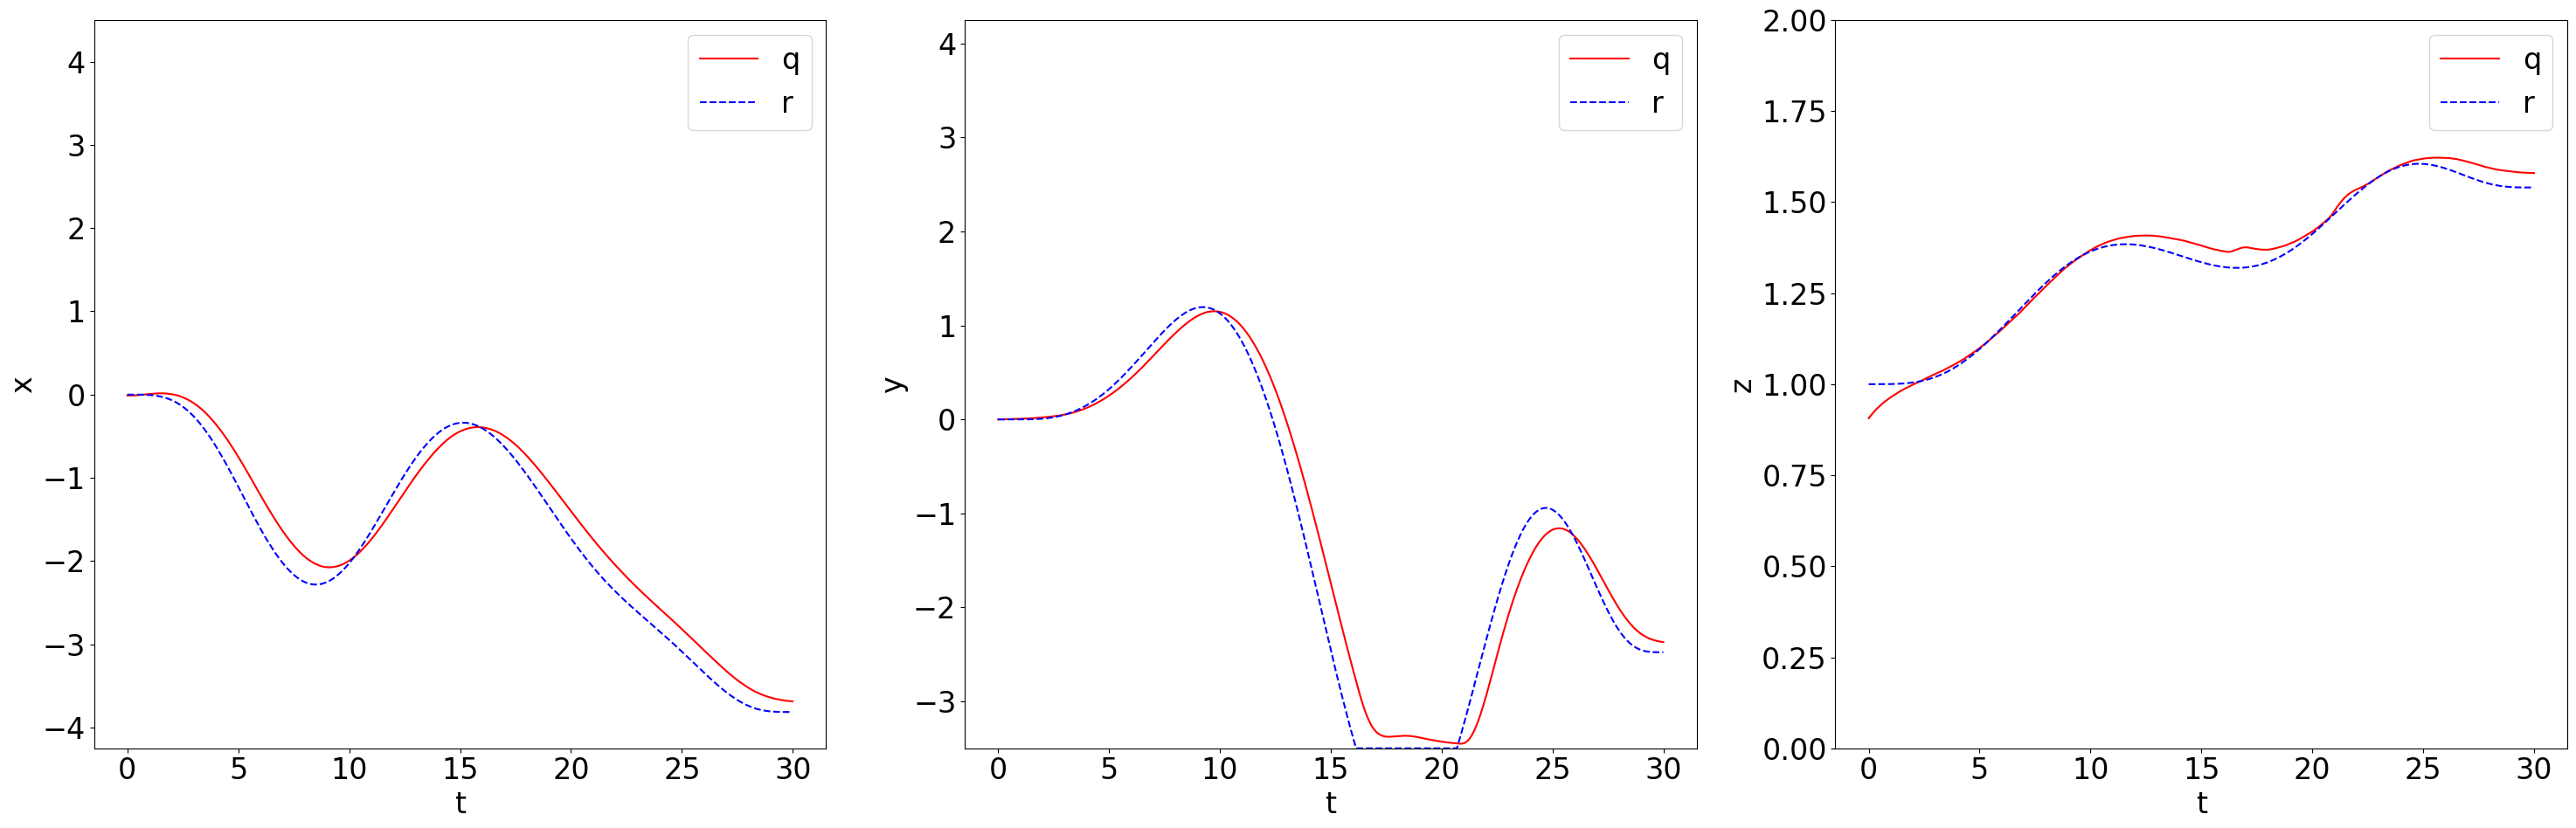

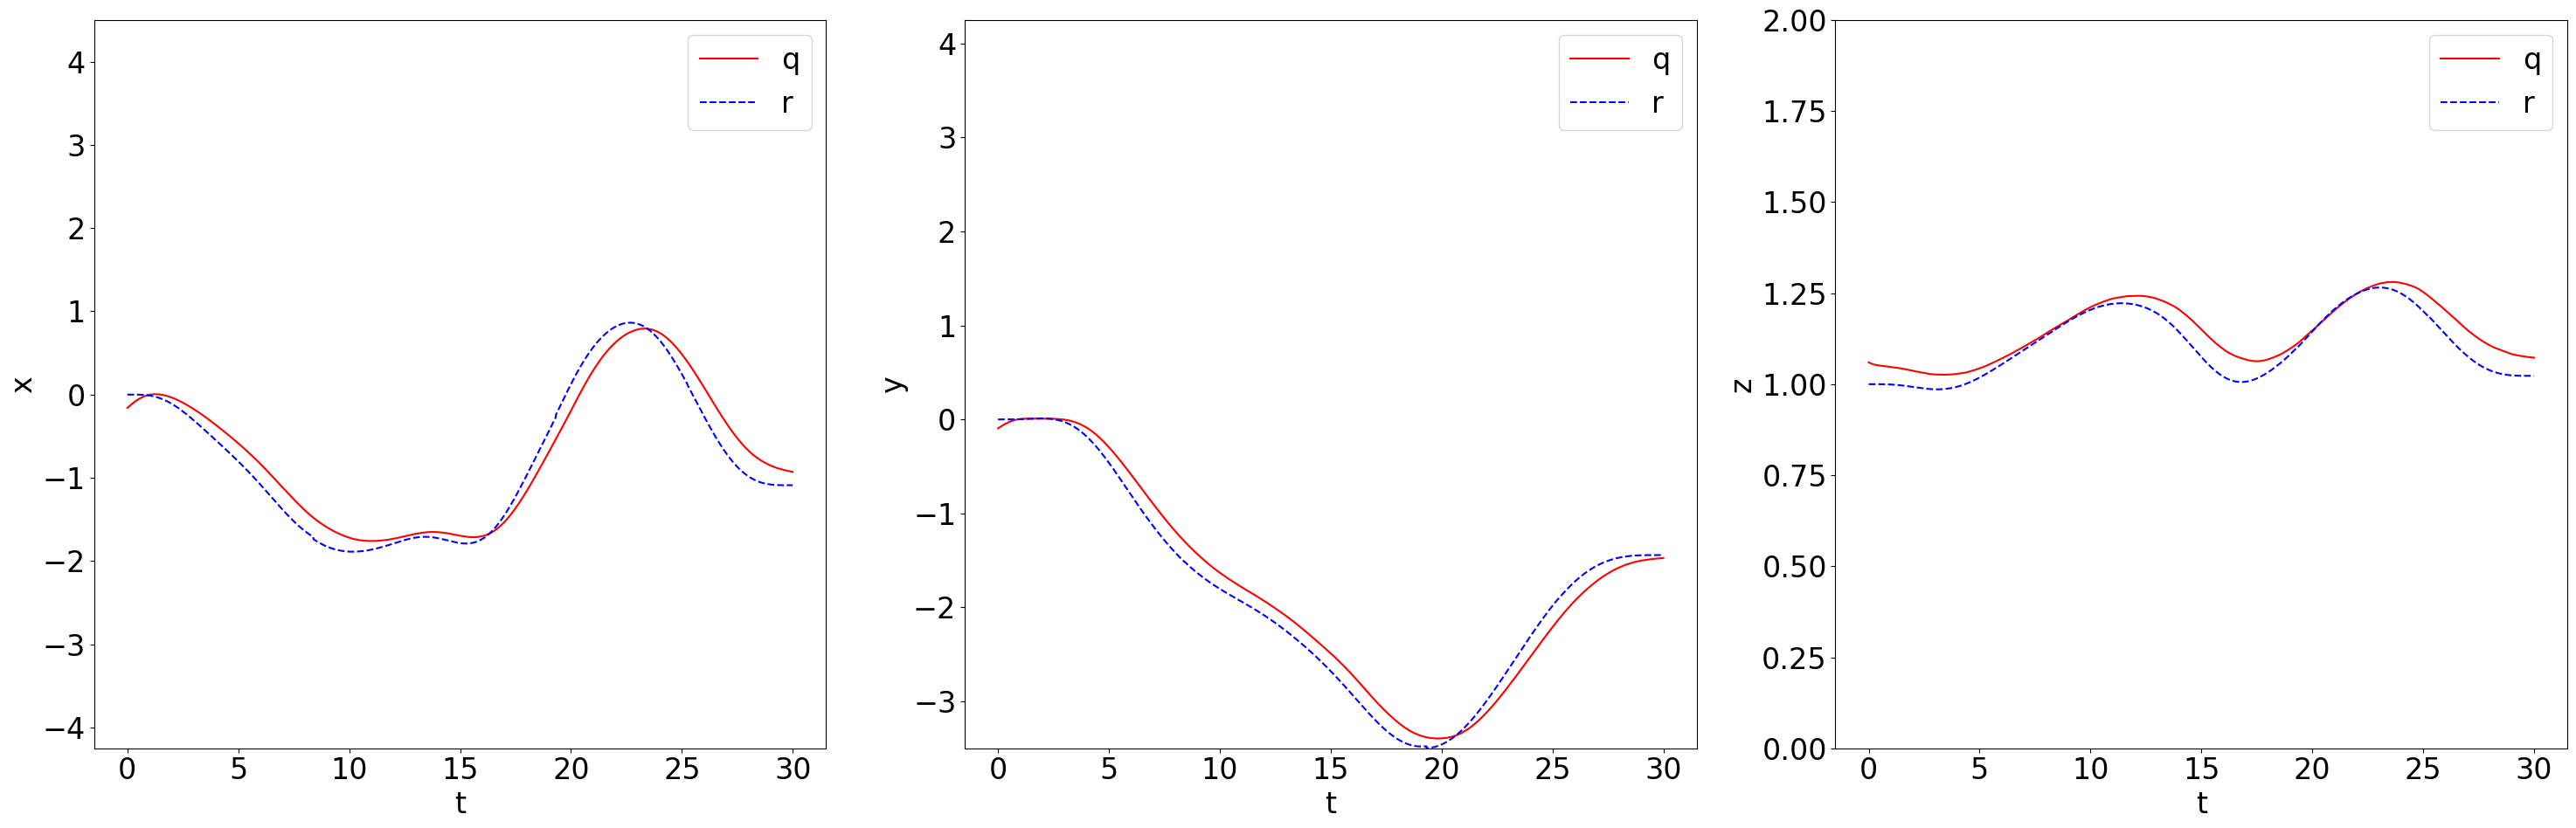

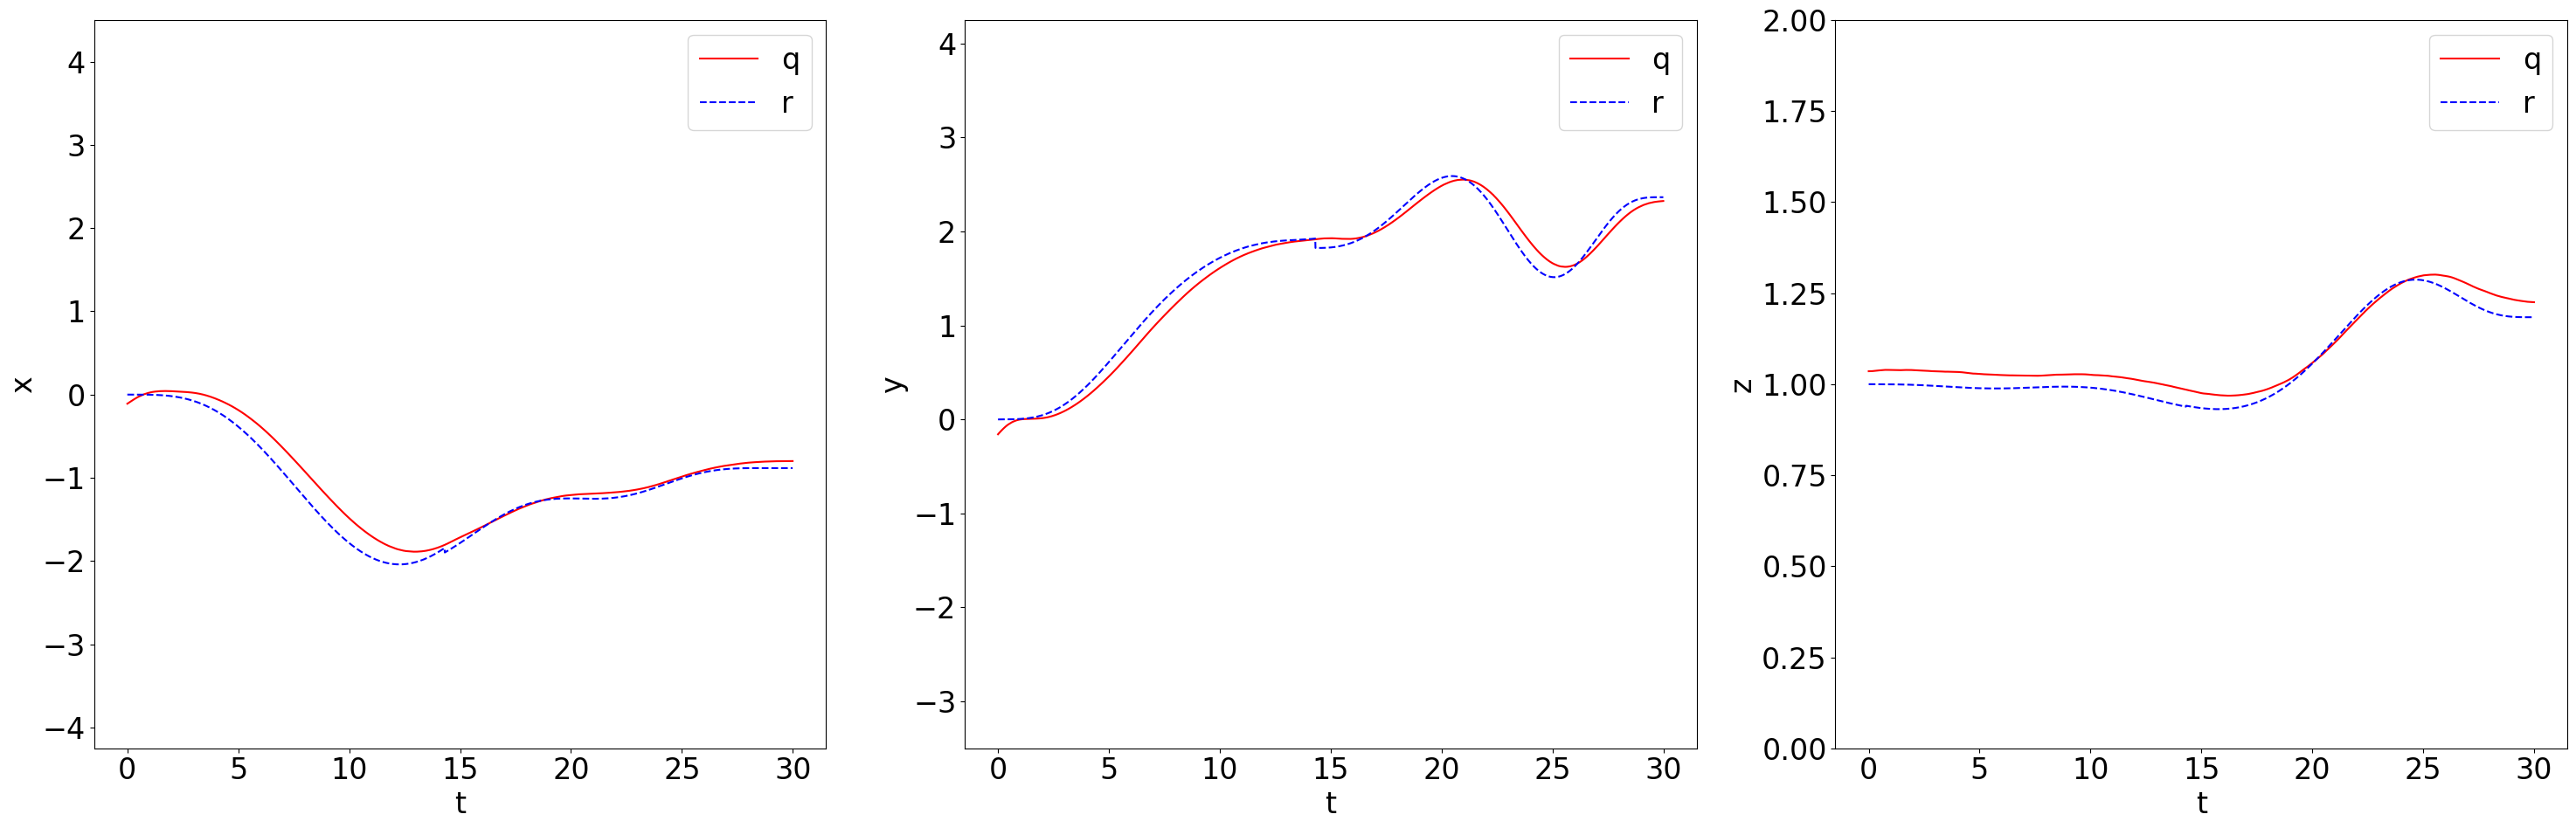

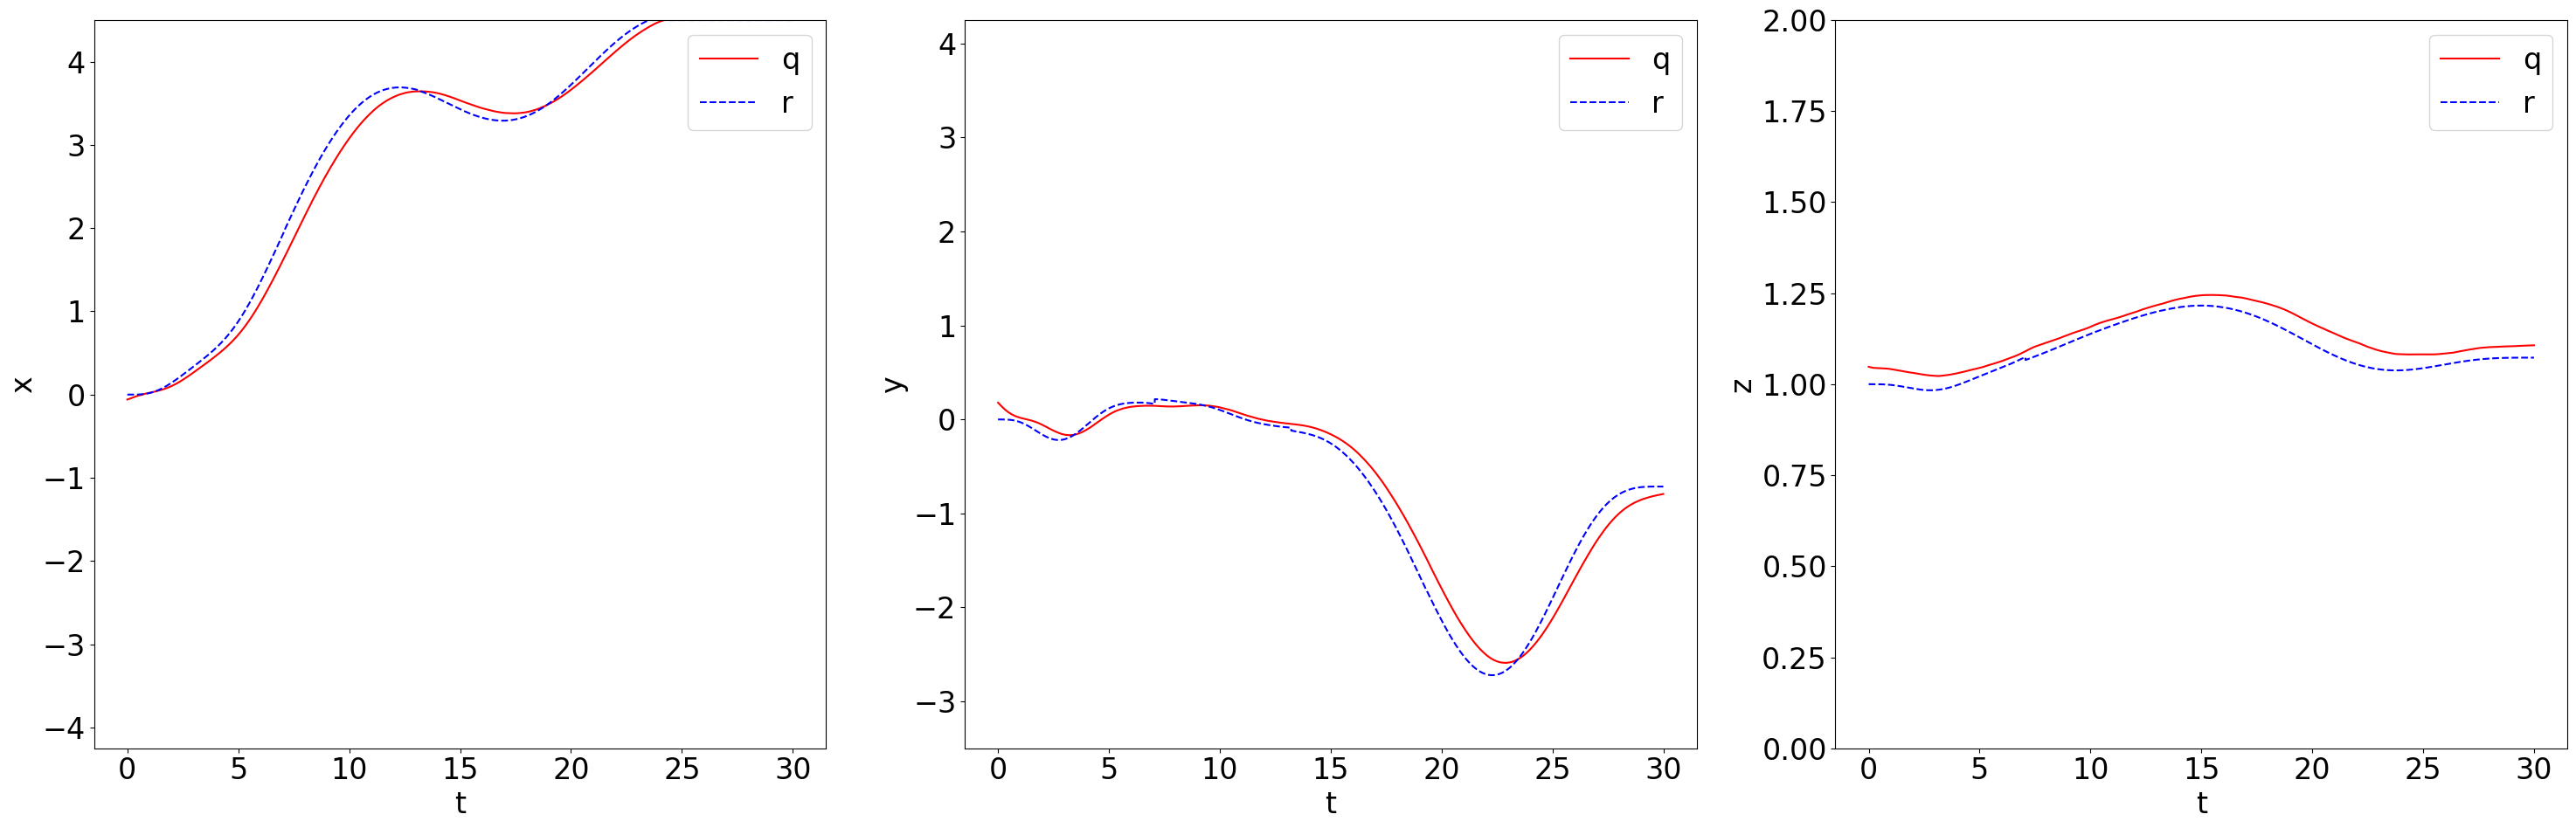

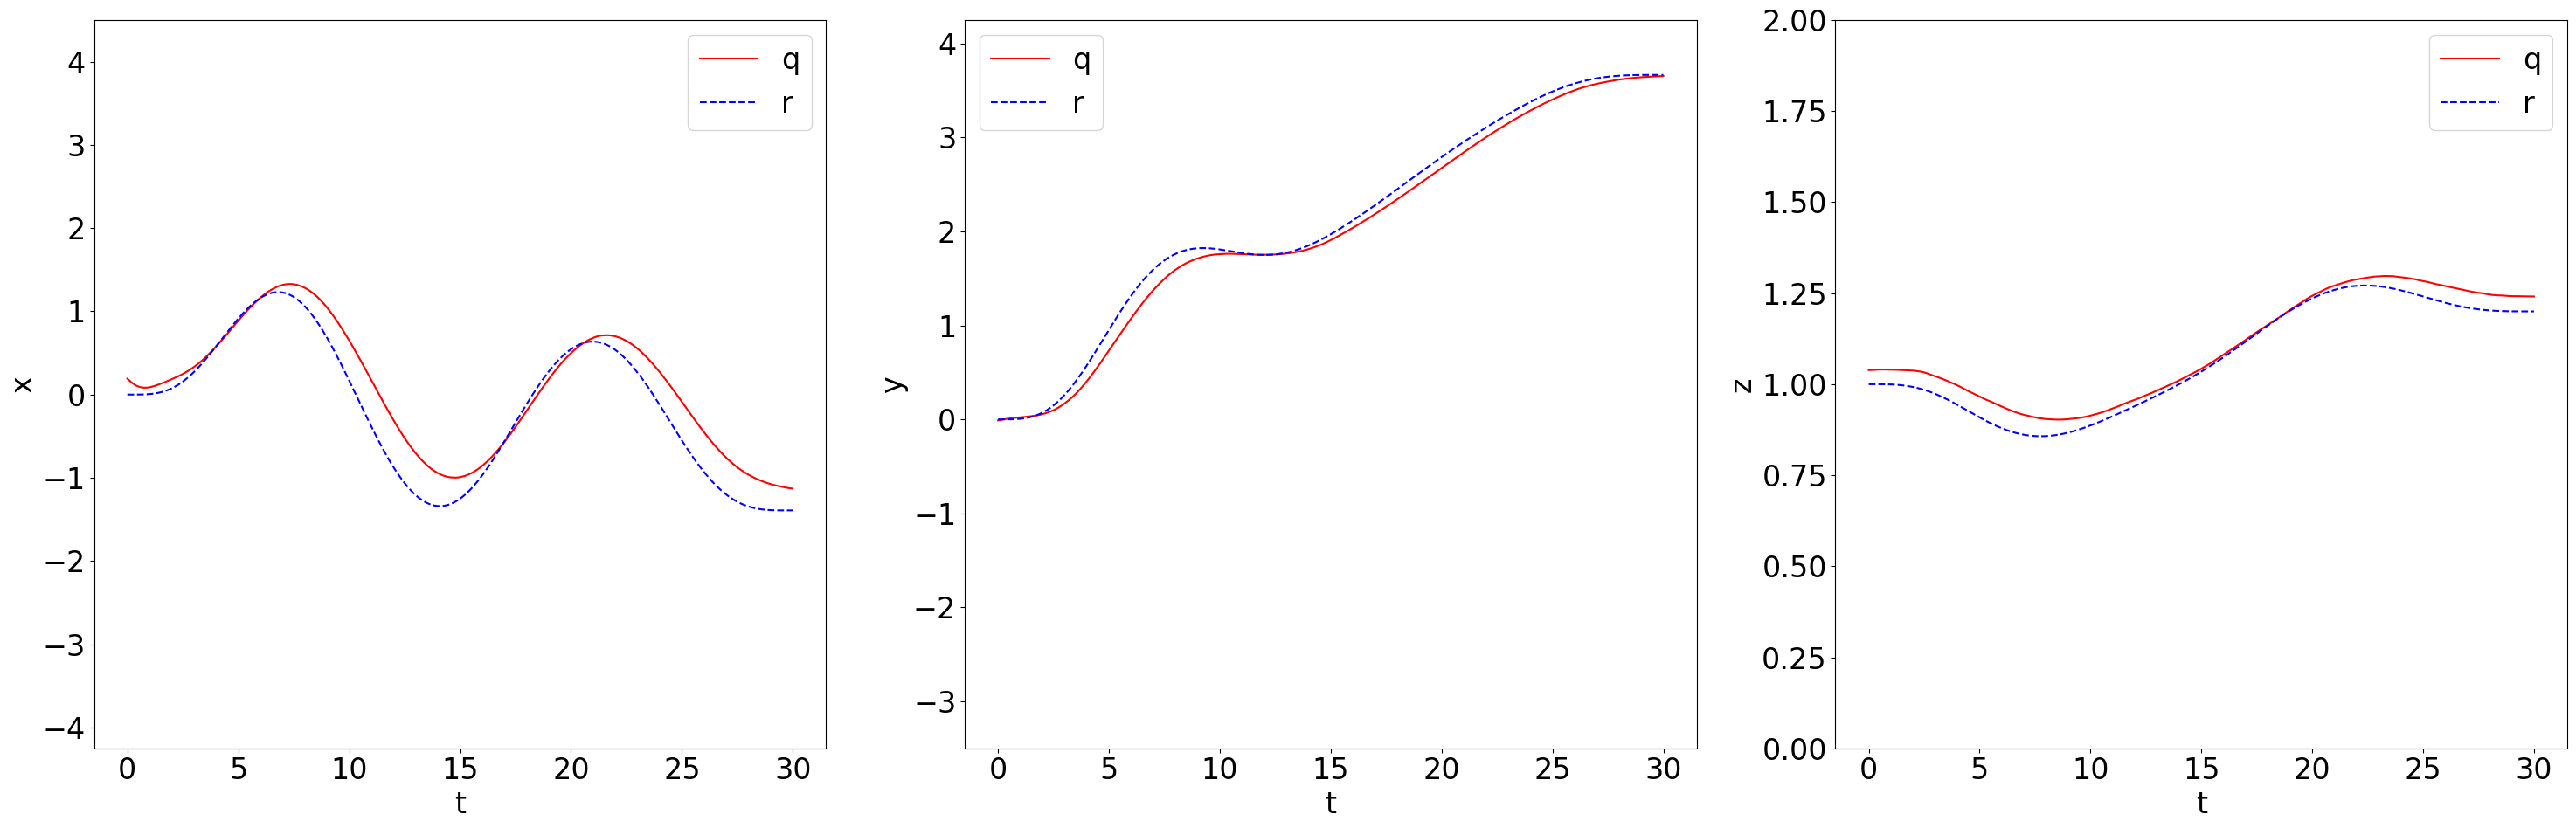

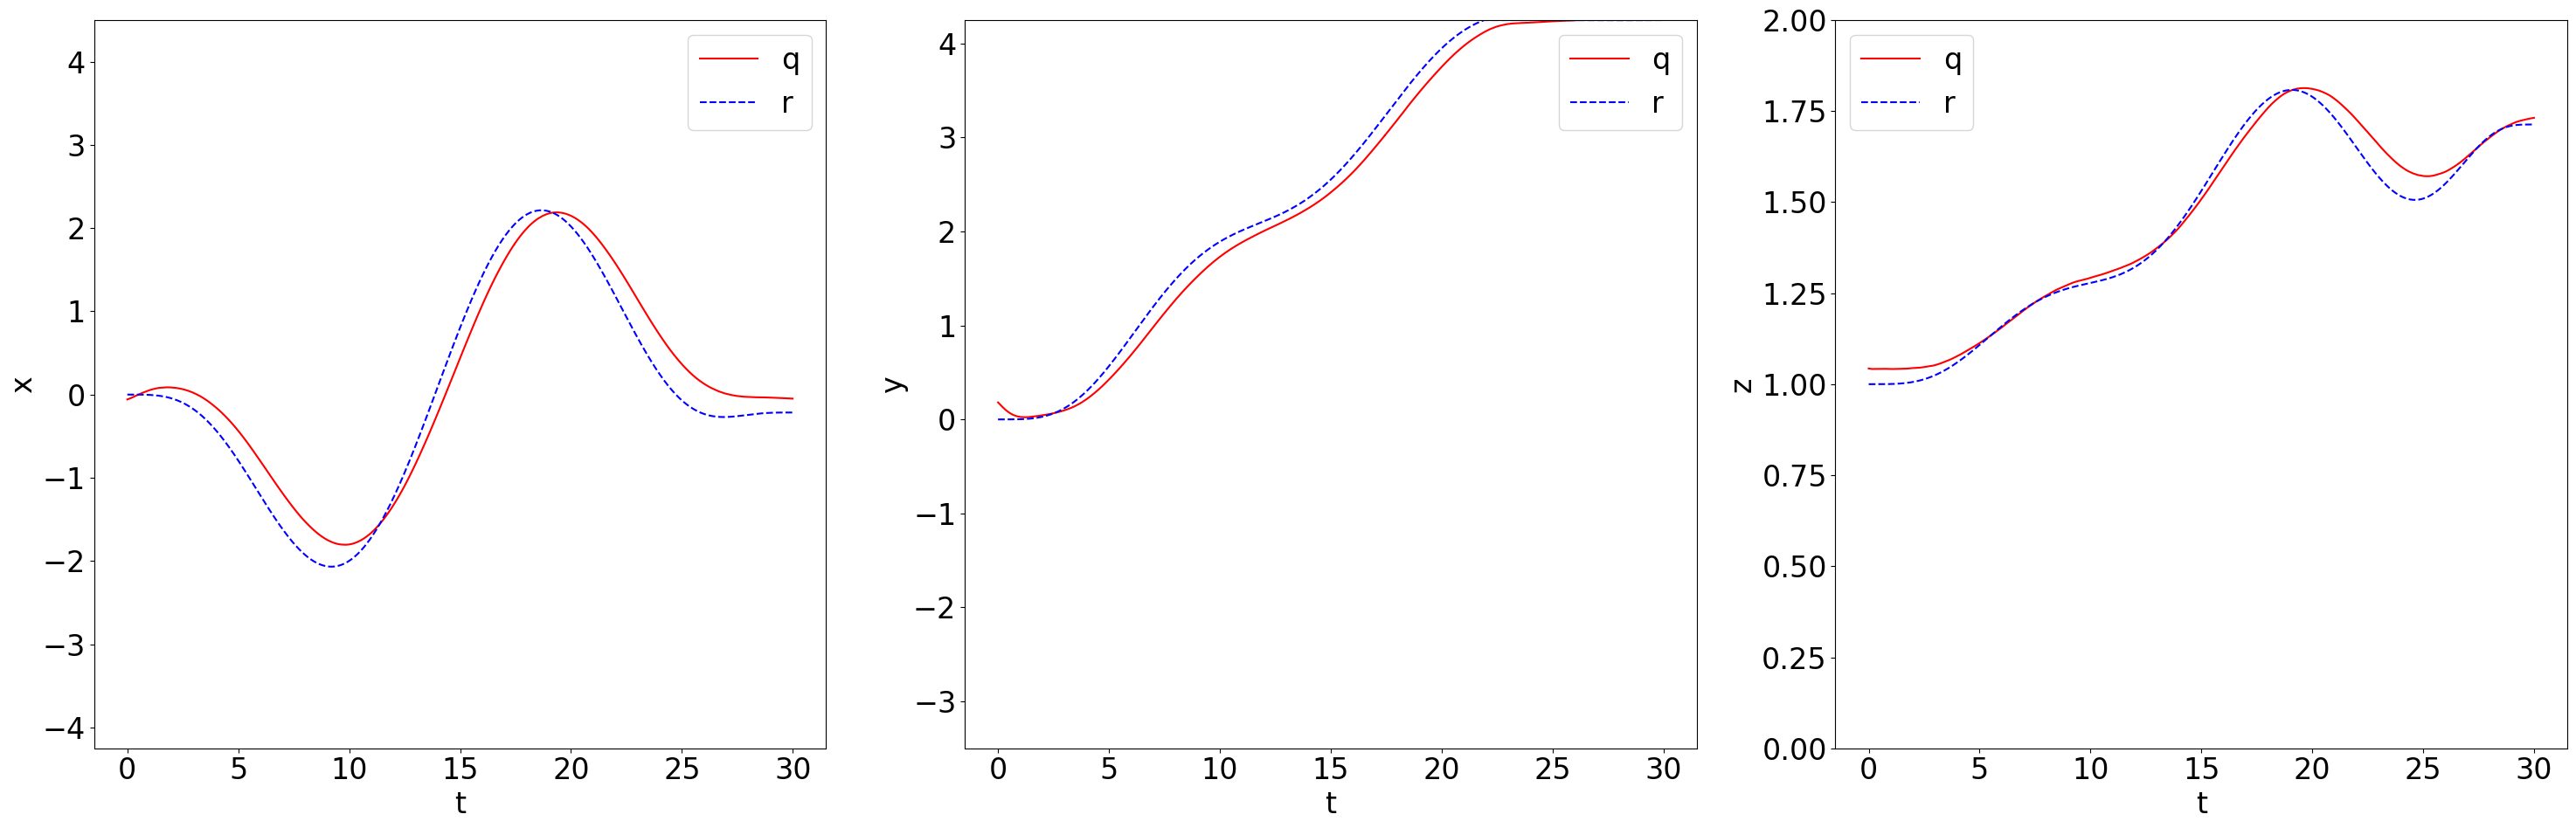

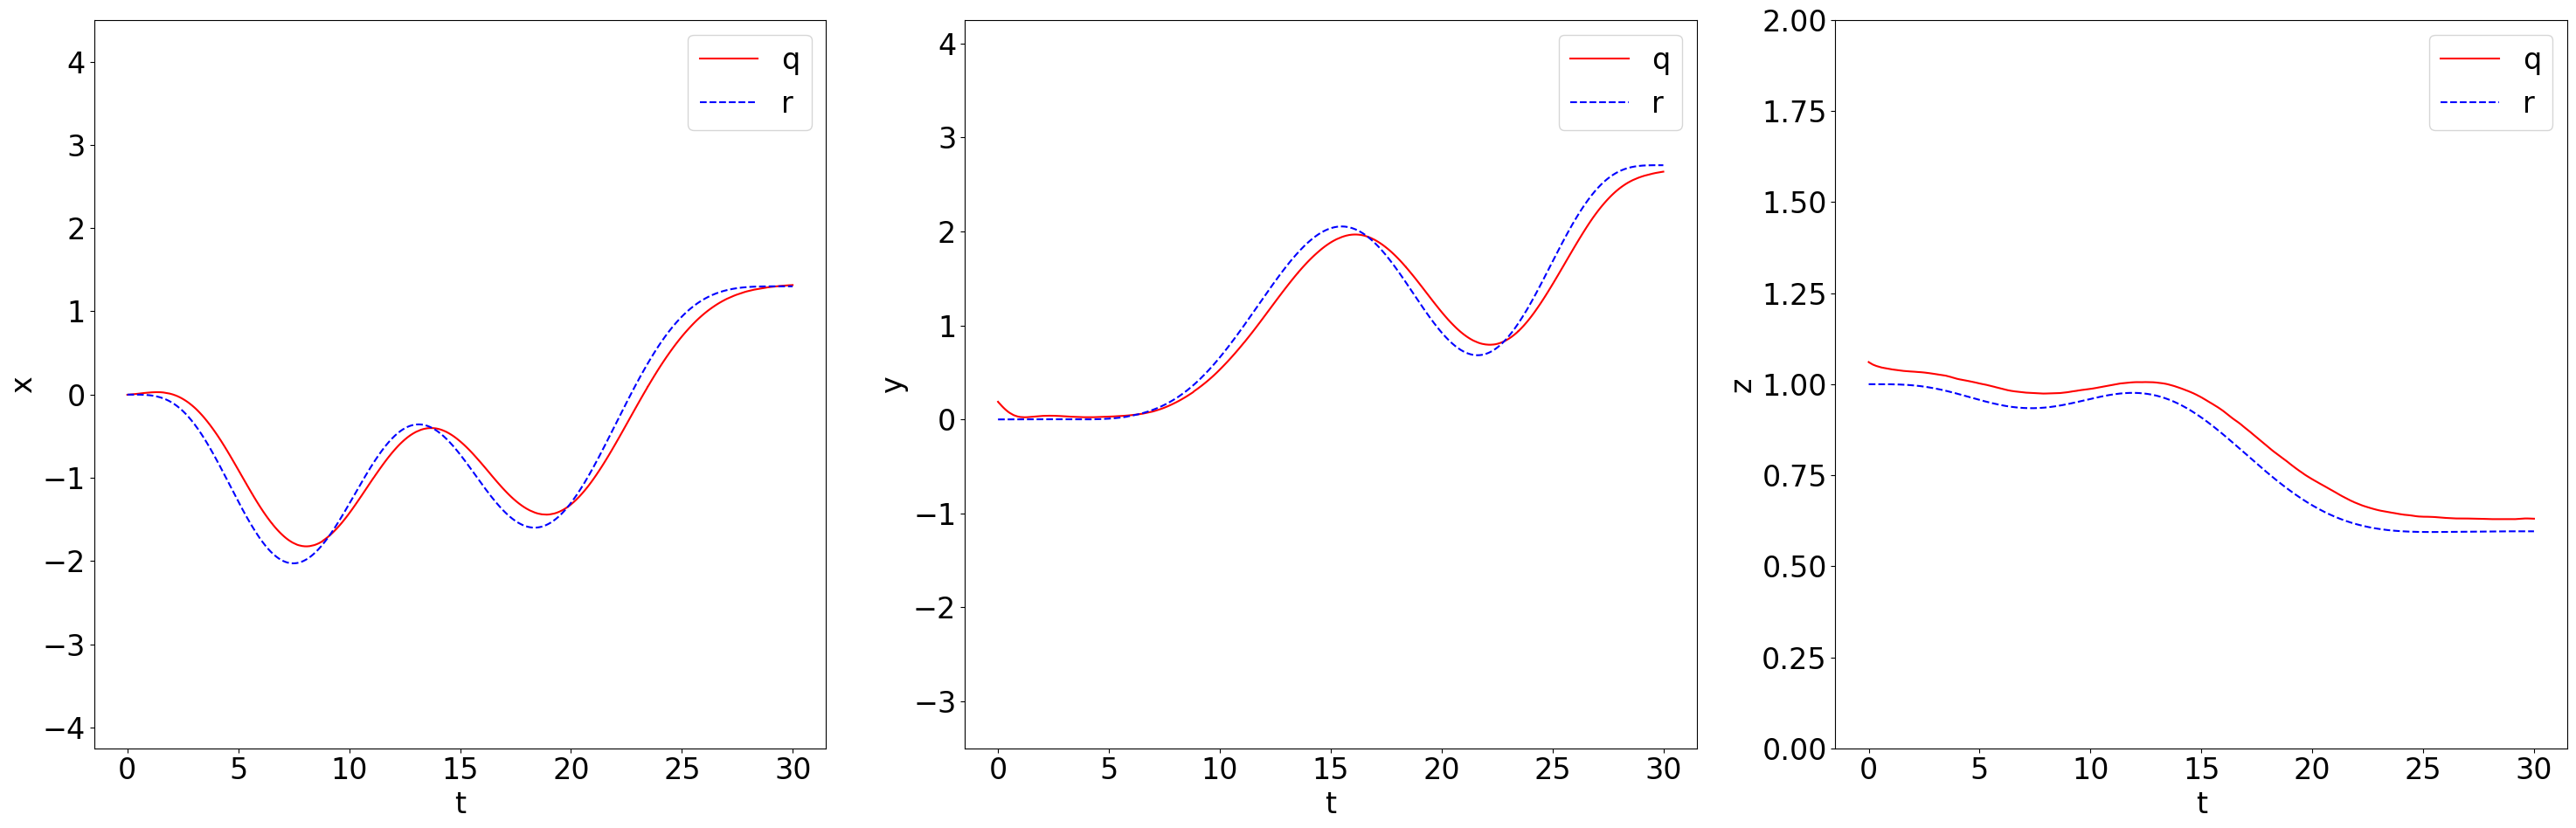

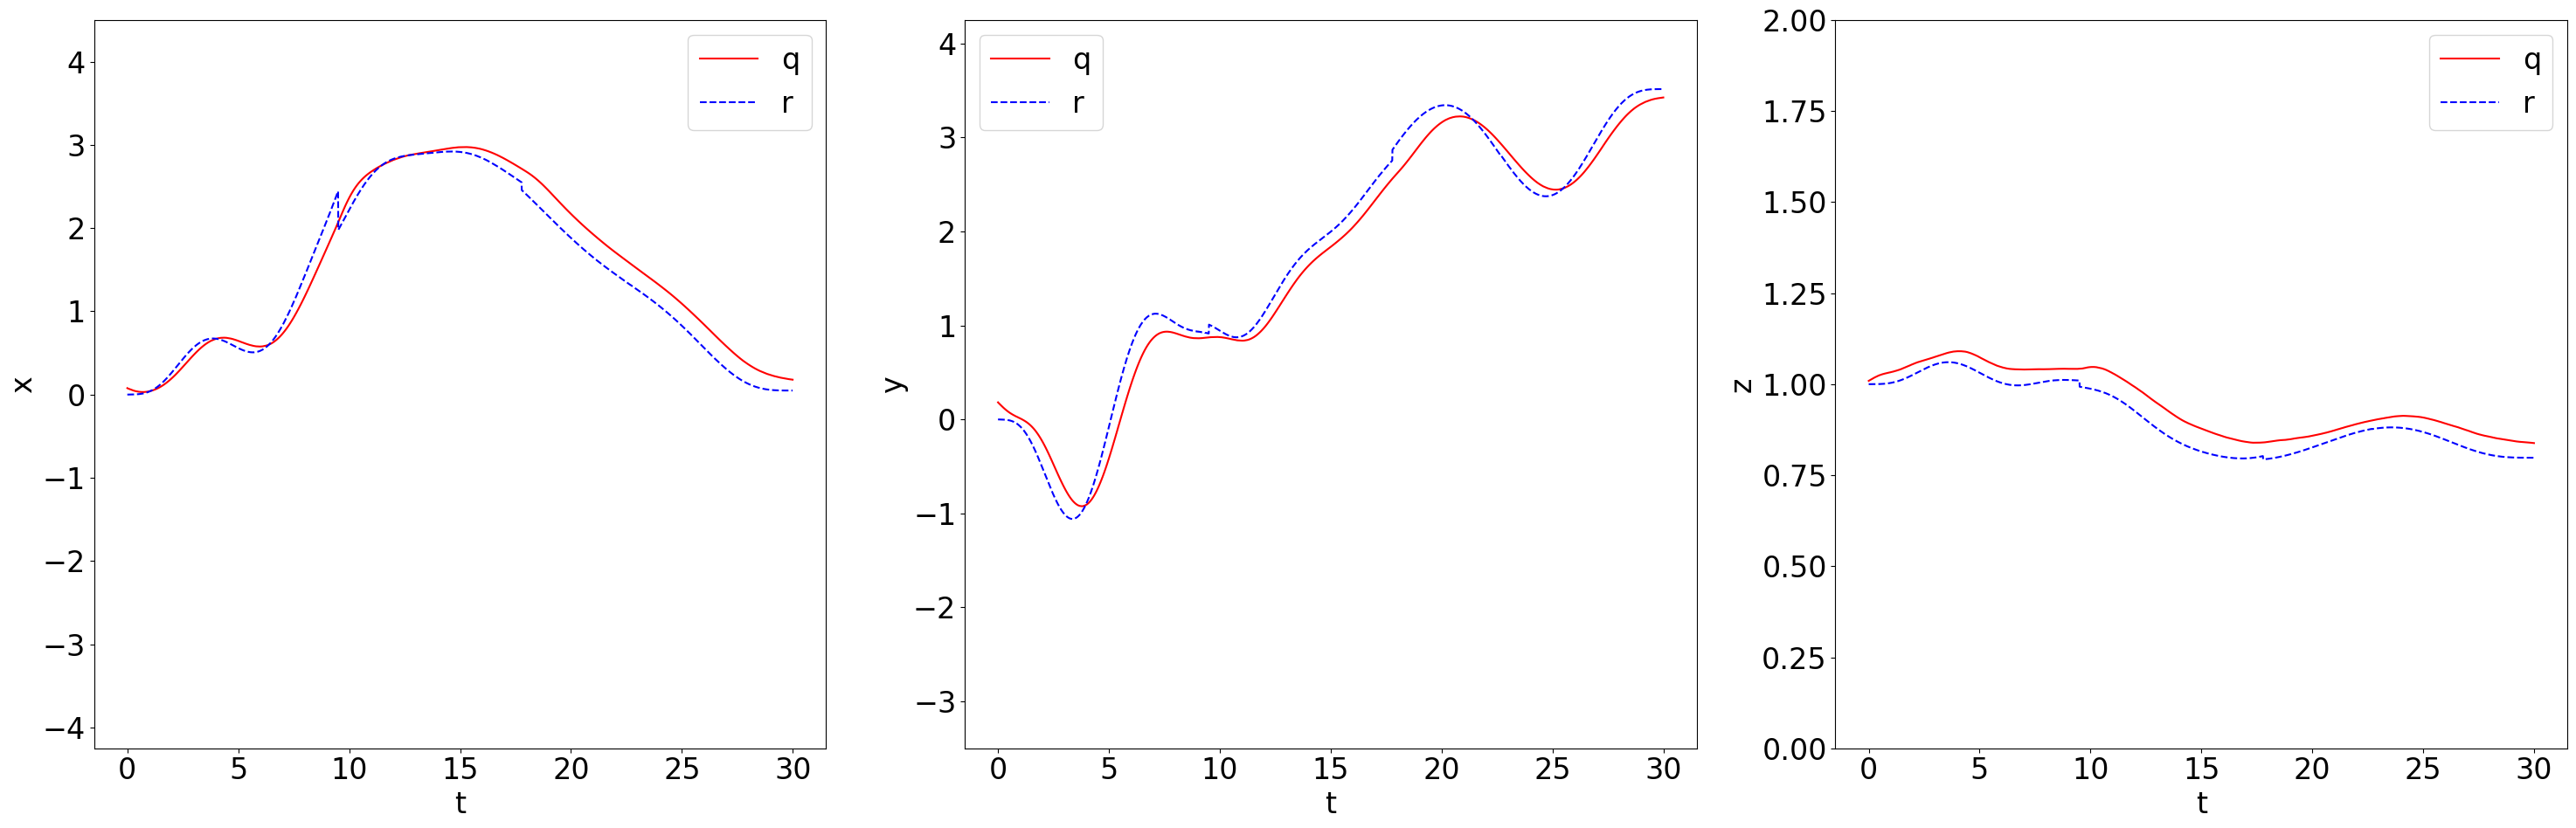

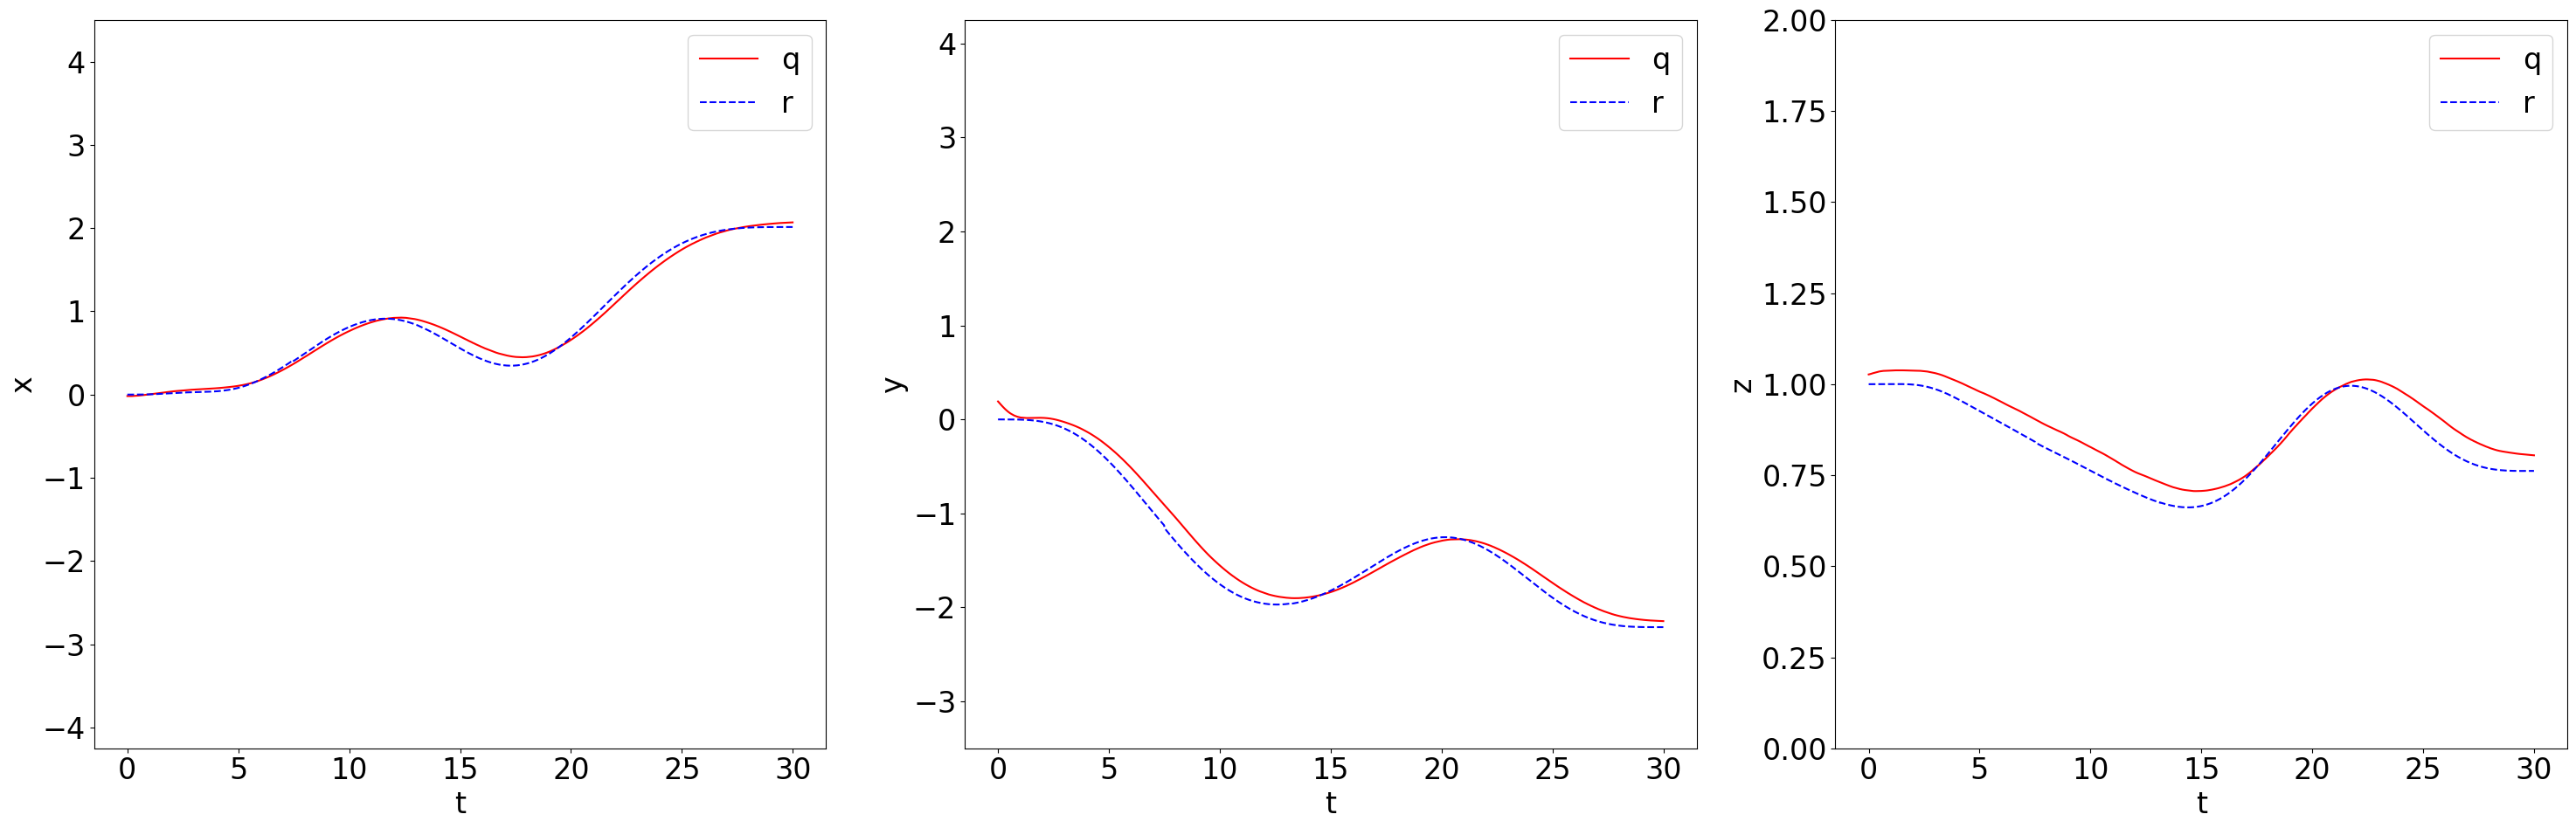

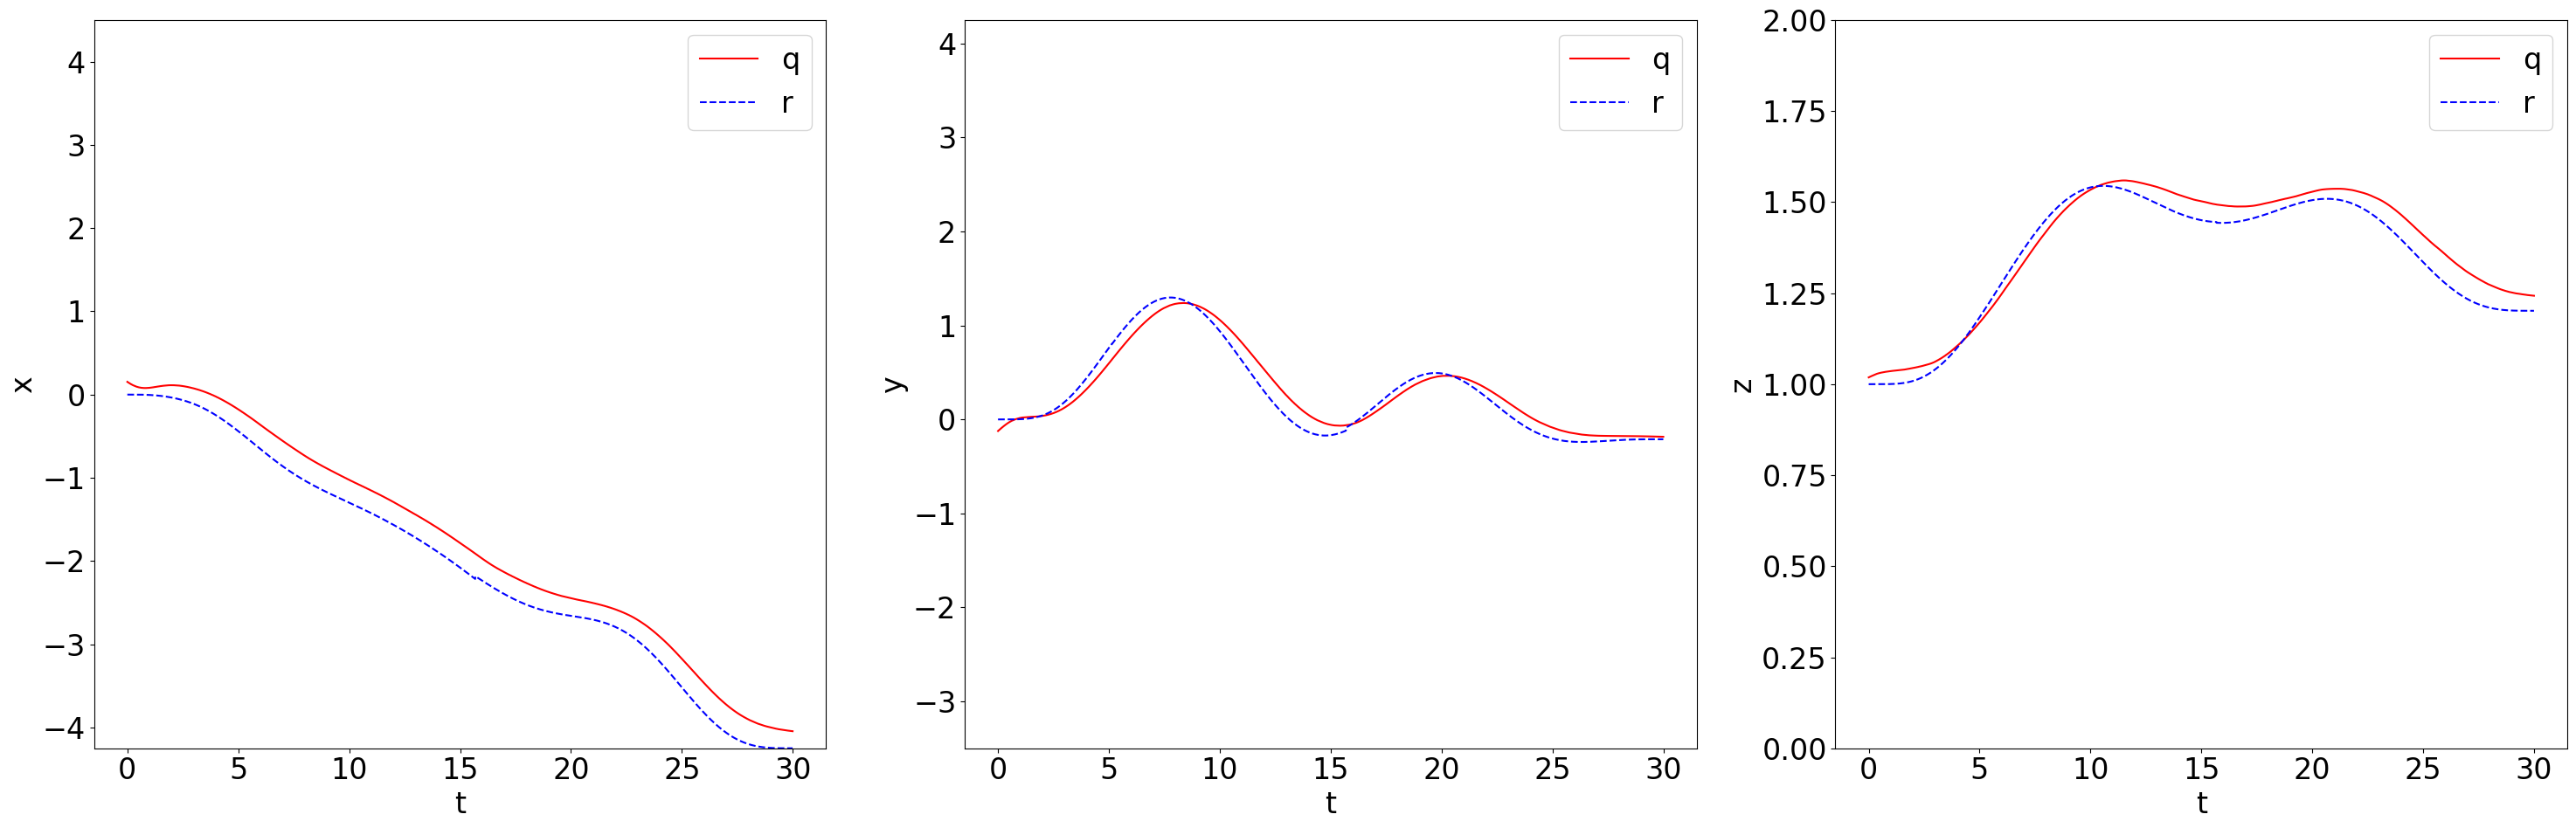

In [4]:
xmin_ = -4.25
xmax_ = 4.5
ymin_ = -3.5
ymax_ = 4.25
zmin_ = 0.0
zmax_ = 2.0

def plot_training_data(filename, traj=0):
    with open(f'data/{filename}', 'rb') as file:
        raw = pickle.load(file)

    num_traj = raw['q'].shape[0]       # total number of raw trajectories
    # ts = jnp.tile(raw['t'][:-1], (num_traj, 1))
    ts = raw['t'][:-1]
    q = raw['q'][traj, :-1]
    dq = raw['dq'][traj, :-1]
    r = raw['r'][traj, :-1]
    dr = raw['dr'][traj, :-1]
    u = raw['u'][traj, :-1, :3]
    quat = raw['quat'][traj, :-1]
    R = jax.vmap(quaternion_to_rotation_matrix, in_axes=0)(quat)
    R_flatten = R.reshape(R.shape[0], R.shape[1], -1)
    omega = raw['omega'][:, :-1]
    data = {'ts': ts, 'q': q, 'dq': dq, 'r': r, 'dr': dr, 'u': u, 'R_flatten': R_flatten, 'omega': omega}

    if os.path.exists('data/figs') == False:
        os.makedirs('data/figs')

    y_limits = [(xmin_, xmax_), (ymin_, ymax_), (zmin_, zmax_)]
        
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, data['q'][:, 0], 'r-', label='q')
    ax[0].plot(ts, data['r'][:, 0], 'b--', label='r')
    ax[0].set_ylabel('x')
    ax[0].set_xlabel('t')
    ax[0].set_ylim(*y_limits[0])
    ax[0].legend()

    ax[1].plot(ts, data['q'][:, 1], 'r-', label='q')
    ax[1].plot(ts, data['r'][:, 1], 'b--', label='r')
    ax[1].set_ylabel('y')
    ax[1].set_xlabel('t')
    ax[1].set_ylim(*y_limits[1])
    ax[1].legend()

    ax[2].plot(ts, data['q'][:, 2], 'r-', label='q')
    ax[2].plot(ts, data['r'][:, 2], 'b--', label='r')
    ax[2].set_ylabel('z')
    ax[2].set_xlabel('t')
    ax[2].set_ylim(*y_limits[2])
    ax[2].legend()

    fig.tight_layout()
    # fig.savefig('data/figs/tracking_{}'.format(filename.replace('.pkl', '.png')))
    # plt.close(fig)

for i in range(10):
    plot_training_data('2024-04-12_00-46-09_traj50_seed0.pkl', i)
    